# Test 1
Código extraido de:  
Detección de anomalías en series temporales por Joaquín Amat Rodrigo y Javier Escobar Ortiz, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://cienciadedatos.net/documentos/py62-deteccion-anomalias-series-temporales.html

In [1]:
# Procesado de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

# Forecastig
# ==============================================================================
import skforecast
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures

# Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print('Versión skforecast:', skforecast.__version__)
print('Versión sklearn:', sklearn.__version__)


Versión skforecast: 0.18.0
Versión sklearn: 1.7.2


Project root: C:\Users\dxnin\Documents\dengue-forecast


<Axes: xlabel='DATE'>

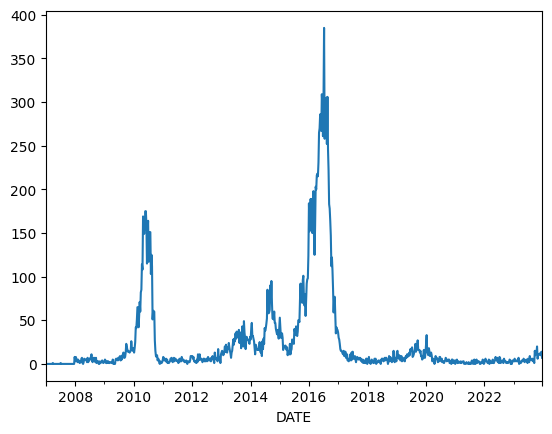

In [2]:
from pathlib import Path
import pandas as pd


PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")
data = pd.read_pickle(f"{PROJECT_ROOT}/data/conformed/data.pkl")
data = data[["CASES"]]
data.CASES.plot()

In [3]:
# Anomalías basadas en IQR
# ==============================================================================
q1 = data["CASES"].quantile(0.25)
q3 = data["CASES"].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Índices de anomalías
anomalies_loc = data[(data["CASES"] > upper_bound) | (data["CASES"] < lower_bound)].index

print(f"Total de anomalías detectadas: {len(anomalies_loc)}")

# Opcional: marcar valores (no modificar el dato)
# data["is_anomaly"] = data.index.isin(anomalies_loc)


Total de anomalías detectadas: 128


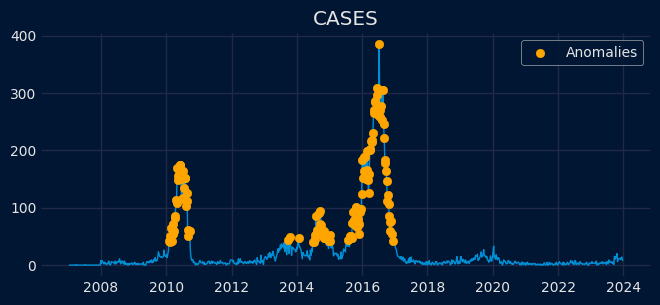

In [4]:
# Gráfico
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data["CASES"], linewidth=1)
ax.scatter(anomalies_loc, data.loc[anomalies_loc, "CASES"], color='orange', label='Anomalies', zorder=2)
ax.set_title('CASES')
ax.legend();


In [5]:
# Partición de datos
# ==============================================================================
end_train = '2020-07-01'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

anomalies_loc_train = [date for date in anomalies_loc if date <= pd.to_datetime(end_train)]
anomalies_loc_test  = [date for date in anomalies_loc if date > pd.to_datetime(end_train)]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"    Anomalies train: {len(anomalies_loc_train)}")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
print(f"    Anomalies test : {len(anomalies_loc_test)}")


Dates train : 2007-01-07 00:00:00 --- 2020-06-28 00:00:00  (n=704)
    Anomalies train: 128
Dates test  : 2020-07-05 00:00:00 --- 2023-12-24 00:00:00  (n=182)
    Anomalies test : 0


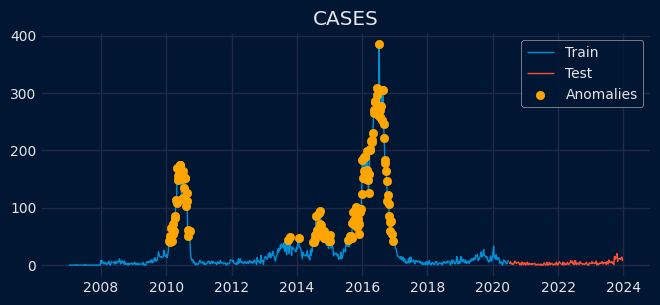

In [6]:
# Plot partitions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data_train['CASES'], label='Train', linewidth=1)
ax.plot(data_test['CASES'], label='Test', linewidth=1)
ax.scatter(anomalies_loc, data.loc[anomalies_loc, "CASES"], color='orange', label='Anomalies', zorder=3)
ax.set_title('CASES')
ax.legend();


In [7]:
# Variables de calendario
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Codificación cíclica
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )

exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['CASES']).tolist()
display(data.head(3))


,steps,"[('datetimefeatures', ...), ('cyclicalfeatures', ...)]"
,transform_input,None
,memory,None
,verbose,False
,variables,'index'
,features_to_extract,"['year', 'month', ...]"
,drop_original,False
,missing_values,'raise'
,dayfirst,False
,yearfirst,False
,utc,None


,CASES,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
DATE,,,,,,,,,,
2007-01-07,0,2007,0.5,0.866025,0.120537,0.992709,-0.781831,0.62349,0.0,1.0
2007-01-14,0,2007,0.5,0.866025,0.239316,0.970942,-0.781831,0.62349,0.0,1.0
2007-01-21,0,2007,0.5,0.866025,0.354605,0.935016,-0.781831,0.62349,0.0,1.0


In [8]:
# Forecaster
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=24)
forecaster = ForecasterRecursive(
                 regressor       = HistGradientBoostingRegressor(random_state=15926, loss='quantile', quantile=0.5),
                 lags            = [1, 3, 4, 5, 6, 13, 14, 15, 16, 17],
                 differentiation = 1,
                 transformer_y   = StandardScaler(),
                 window_features = window_features,
             )
forecaster.fit(
    y    = data.loc[:end_train, 'CASES'],
    exog = data.loc[:end_train, exog_features]
)
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: HistGradientBoostingRegressor 
Lags: [ 1  3  4  5  6 13 14 15 16 17] 
Window features: ['roll_mean_24', 'roll_min_24', 'roll_max_24'] 
Window size: 25 
Series name: CASES 
Exogenous included: True 
Exogenous names: 
    day_of_week_cos, day_of_week_sin, hour_cos, hour_sin, month_cos, month_sin,
    week_cos, week_sin, year 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [Timestamp('2007-01-07 00:00:00'), Timestamp('2020-06-28 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: 
    {'categorical_features': 'from_dtype', 'early_stopping': 'auto',
    'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1,
    'loss': 'quantile', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0,
    'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20,
    'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': 0.5,
    'random_state': 15926, 'scoring': 'loss', 'tol': 1e-07,
    'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-11-27 00:04:43 
Last fit date: 2025-11-27 00:04:46 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

In [9]:
# Backtesting con datos de entrenamiento
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = None, 
        steps              = 1,
        differentiation    = 1,
     )

metric_train, predictions_train = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.loc[:end_train, 'CASES'],
                                    exog       = data.loc[:end_train, exog_features],
                                    cv         = cv,
                                    metric     = 'mean_absolute_error'
                                )

results_train = predictions_train.copy()
results_train['y_true'] = data.loc[:end_train, 'CASES']
results_train['residual'] = results_train['y_true'] - results_train['pred']
results_train['residual_abs'] = np.abs(results_train['residual'])
results_train.head(3)


  0%|          | 0/679 [00:00<?, ?it/s]

,fold,pred,y_true,residual,residual_abs
2007-07-01,0,0.008426,0,-0.008426,0.008426
2007-07-08,1,0.007124,1,0.992876,0.992876
2007-07-15,2,0.544150,0,-0.544150,0.544150


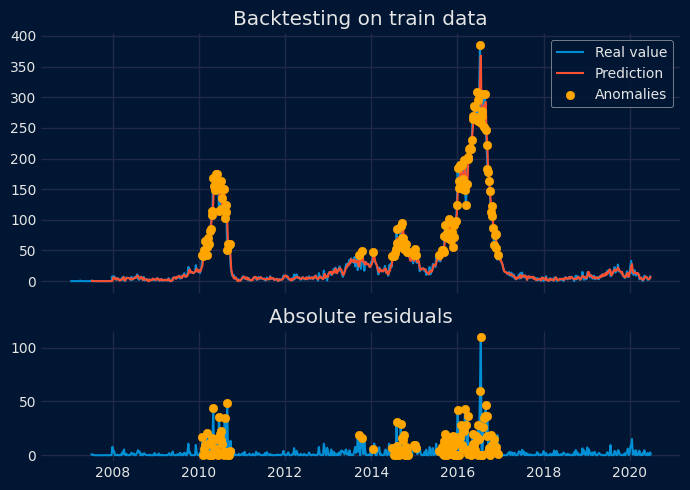

In [10]:
# Gráfico predicciones, valor real y residuos
# ==============================================================================
fig, axs = plt.subplots(
    2, 1, figsize=(7, 5), gridspec_kw={"height_ratios": [2, 1]}, sharex=True
)
axs[0].plot(data.loc[:end_train, "CASES"], label="Real value")
axs[0].plot(predictions_train["pred"], label="Prediction")
axs[0].scatter(
    anomalies_loc_train,
    data.loc[anomalies_loc_train, "CASES"],
    zorder=2,
    color="orange",
    label="Anomalies",
)
axs[0].set_title("Backtesting on train data")
axs[0].legend()
axs[1].plot(results_train["residual_abs"], label="Absolute residuals", zorder=2)
axs[1].set_title("Absolute residuals")
top_residuals_train = (
    results_train.sort_values("residual_abs", ascending=False).head(len(anomalies_loc_train))
)
top_residuals_train["is_anomaly"] = top_residuals_train.index.isin(anomalies_loc_train)
axs[1].scatter(
    anomalies_loc_train,
    results_train.loc[anomalies_loc_train, "residual_abs"],
    zorder=2,
    color="orange",
    label="Anomalies",
)
plt.tight_layout()


In [11]:
print(f"Percentage of true positives: {100 * top_residuals_train['is_anomaly'].mean():.2f}%")
print(f"Percentage of false positives: {100 * (~top_residuals_train['is_anomaly']).mean():.2f}%")

Percentage of true positives: 63.28%
Percentage of false positives: 36.72%


In [12]:
# Backtesting en test
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data_train),
        steps              = 1,
        refit              = False,
        differentiation    = 1,
     )

metric_test, predictions_test = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.loc[:, 'CASES'],
                                    exog       = data.loc[:, exog_features],
                                    cv         = cv,
                                    metric     = 'mean_absolute_error'
                                )
results_test = predictions_test.copy()
results_test['y_true'] = data.loc[end_train:, 'CASES']
results_test['residual'] = results_test['y_true'] - results_test['pred']
results_test['residual_abs'] = np.abs(results_test['residual'])
results_test.head(3)


  0%|          | 0/182 [00:00<?, ?it/s]

,fold,pred,y_true,residual,residual_abs
2020-07-05,0,7.729496,4,-3.729496,3.729496
2020-07-12,1,6.573877,3,-3.573877,3.573877
2020-07-19,2,3.527613,6,2.472387,2.472387


In [13]:
from utils import *
evaluate_model(data.loc[end_train:, "CASES"], results_test["pred"])

   📊 --- Model Evaluation ---
   RMSE: 2.7325
   MAE: 2.0455
   ❌ Modelo NO candidato (no mejora lo esperado sobre naive)


{'RMSE': 2.732454971476592, 'MAE': 2.045492122061995}

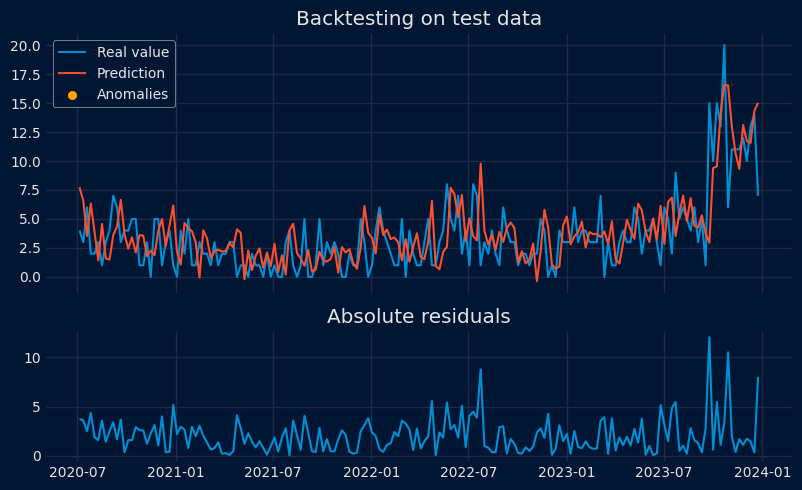

In [14]:
# Gráfico predicciones, valor real y residuos
# ==============================================================================
fig, axs = plt.subplots(
    2, 1, figsize=(8, 5), gridspec_kw={"height_ratios": [2, 1]}, sharex=True
)
axs[0].plot(data.loc[end_train:, "CASES"], label="Real value")
axs[0].plot(results_test["pred"], label="Prediction")
axs[0].scatter(
    anomalies_loc_test,
    data.loc[anomalies_loc_test, "CASES"],
    color="orange",
    zorder=2,
    label="Anomalies",
)
axs[0].set_title("Backtesting on test data")
axs[0].legend()
axs[1].plot(results_test["residual_abs"], label="Absolute residuals")
axs[1].set_title("Absolute residuals")
axs[1].scatter(
    anomalies_loc_test,
    results_test.loc[anomalies_loc_test, "residual_abs"],
    color="orange",
    zorder=2,
    label="Anomalies",
)
plt.tight_layout()


# Test 2
Código extraido de:  
Forecasting demanda intermitente con skforecast por Joaquín Amat Rodrigo y Javier Escobar Ortiz, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py48-forecasting-demanda-intermitente.html

In [16]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Modelado y Forecasting
# ==============================================================================
import skforecast
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")

Version skforecast: 0.18.0


Project root: C:\Users\dxnin\Documents\dengue-forecast


<Axes: xlabel='DATE'>

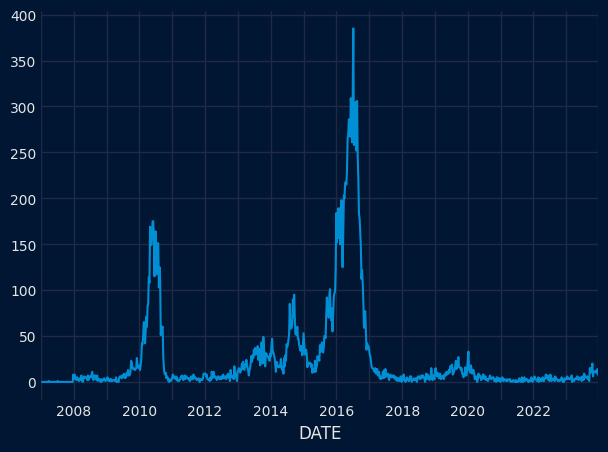

In [17]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")
data = pd.read_pickle(f"{PROJECT_ROOT}/data/conformed/data.pkl")
data = data[["CASES"]]
data["YEAR"] = data.index.year
data.CASES.plot()

In [18]:
# División train-valalidación-test
# ======================================================================================
end_train = '2017-01-01'
end_validation = '2020-07-01'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Fechas train      : 2007-01-07 00:00:00 --- 2017-01-01 00:00:00  (n=522)
Fechas validation : 2017-01-01 00:00:00 --- 2020-06-28 00:00:00  (n=183)
Fechas test       : 2020-07-05 00:00:00 --- 2023-12-24 00:00:00  (n=182)


In [19]:
# Gráfico time series
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_train.index, y=data_train['CASES'], name="train", mode="lines")
trace2 = go.Scatter(x=data_val.index, y=data_val['CASES'], name="validation", mode="lines")
trace3 = go.Scatter(x=data_test.index, y=data_test['CASES'], name="test", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.update_layout(
    title="Serie temporal de usuarios",
    xaxis_title="Date time",
    yaxis_title="Usuarios",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=50, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()


In [20]:
# Boxplot para la estacionalidad semanal
# ==============================================================================
fig = px.box(
        data,
        x="YEAR",
        y="CASES",
        title = 'Distribusión de usuarios por día de la semana',
        width=600,
        height=300
     )
median_values = data.groupby('YEAR')['CASES'].median()
fig.add_trace(
    go.Scatter(
        x=median_values.index,
        y=median_values.values,
        mode='lines+markers',
        line=dict(color='blue', dash='dash'),
        showlegend=False
    )
)
fig.update_layout(margin=dict(l=20, r=20, t=35, b=20))
fig.show()


In [21]:
def custom_metric(y_true, y_pred):
    """
    Calcular el error medio absoluto utilizando sólo los valores predichos para
    los días laborables de 9:00 a 20:00.
    """

    year = y_true.index.year
    mask = ~year.isin([2010, 2015, 2016])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric


In [22]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(
                                 learning_rate = 0.1,
                                 max_depth     = 5,
                                 n_estimators  = 500,
                                 random_state  = 123,
                                 verbose       = -1
                             ),
                 lags = 24
             )
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: None 
Window size: 24 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 500, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-11-27 00:05:08 
Last fit date: None 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

In [23]:
# Backtesting del periodo de test
# ==============================================================================
cv = TimeSeriesFold(steps = 1, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['CASES'],
                          cv         = cv,
                          metric     = custom_metric
                      )
metric


  0%|          | 0/182 [00:00<?, ?it/s]

,custom_metric
0,1.851041


In [24]:
# Reemplazar por cero las predicciones para años específicos
# ==============================================================================

year = data_test.index.year

closed_years = year.isin([2010, 2015, 2016])

predictions[closed_years] = 0


In [25]:
from utils import *
evaluate_model(data_test['CASES'], predictions['pred'])

   📊 --- Model Evaluation ---
   RMSE: 2.4432
   MAE: 1.8510
   ❌ Modelo NO candidato (no mejora lo esperado sobre naive)


{'RMSE': 2.443162460298472, 'MAE': 1.8510413689802683}

In [26]:
# Gráfico real vs predicción en el periodo de test
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['CASES'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Valores reales vs predicciones en el periodo de test",
    xaxis_title="Date time",
    yaxis_title="CASES",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=50, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()
